In [7]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.cluster.vq import kmeans, vq
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
v = np.load('Experiments/PreprocessedData/MOL-001.npy')

In [ ]:
from preprocessing import filter_volume

In [30]:
def calculate_perfusion_maps(volume_4d, time_values=None, aif_method='auto', 
                             n_clusters=5, smooth_sigma=0.5, truncate_svd=0.2,
                             spatial_smooth=.5, smooth_output=True):
    """
    Calculate perfusion maps from 4D volume data with automated curve selection.
    
    Parameters:
    -----------
    volume_4d : numpy.ndarray
        4D array with dimensions (time, z, y, x) or (time, y, x) for 2D+time data
    time_values : numpy.ndarray, optional
        Array of time points in seconds. If None, assumes uniform sampling at 1s intervals.
    aif_method : str or tuple, optional
        Method for AIF selection: 'auto', 'kmeans', 'pca', 'features', or ROI coordinates
    n_clusters : int, optional
        Number of clusters for k-means based curve classification
    smooth_sigma : float, optional
        Sigma for Gaussian smoothing of concentration curves
    truncate_svd : float, optional
        Relative threshold for singular value truncation (0-1)
    spatial_smooth : float, optional
        Sigma for spatial Gaussian smoothing of input volume (0 = no smoothing)
    smooth_output : bool, optional
        Whether to apply spatial smoothing to output perfusion maps
        
    Returns:
    --------
    dict
        Dictionary containing perfusion maps and selected curves
    """
    # Get dimensions and handle 2D+time vs 3D+time
    if len(volume_4d.shape) == 4:  # 3D+time
        n_timepoints, n_slices, n_rows, n_cols = volume_4d.shape
        is_3d = True
    else:  # 2D+time
        n_timepoints, n_rows, n_cols = volume_4d.shape
        n_slices = 1
        is_3d = False
        volume_4d = volume_4d.reshape(n_timepoints, 1, n_rows, n_cols)
    
    # Apply spatial smoothing to input volume if requested
    if spatial_smooth > 0:
        volume_smoothed = np.zeros_like(volume_4d)
        for t in range(n_timepoints):
            if is_3d:
                for z in range(n_slices):
                    volume_smoothed[t, z] = gaussian_filter(volume_4d[t, z], sigma=spatial_smooth)
            else:
                volume_smoothed[t, 0] = gaussian_filter(volume_4d[t, 0], sigma=spatial_smooth)
        volume_4d = volume_smoothed
    
    # Create time axis if not provided
    if time_values is None:
        time_values = np.arange(n_timepoints)
    dt = np.mean(np.diff(time_values))
    
    # Create output maps
    cbf_map = np.zeros((n_slices, n_rows, n_cols))
    cbv_map = np.zeros((n_slices, n_rows, n_cols))
    mtt_map = np.zeros((n_slices, n_rows, n_cols))
    delay_map = np.zeros((n_slices, n_rows, n_cols))
    tmax_map = np.zeros((n_slices, n_rows, n_cols))
    tissue_type_map = np.zeros((n_slices, n_rows, n_cols), dtype=int)
    # --------------------------------------------------------------------------
    # Automated Curve Selection and Classification
    # --------------------------------------------------------------------------
    
    # Extract all curves and reshape for analysis
    curves = volume_4d.reshape(n_timepoints, -1)
    n_voxels = curves.shape[1]
    
    # Filter out flat or noisy curves
    curve_std = np.std(curves, axis=0)
    valid_curves_mask = curve_std > np.percentile(curve_std, 10)
    valid_curves = curves[:, valid_curves_mask]
    valid_indices = np.where(valid_curves_mask)[0]
    
    # Prepare curves for analysis
    # Baseline correction
    baseline_idx = max(1, int(n_timepoints * 0.1))  # Use first 10% as baseline
    baselines = np.mean(valid_curves[:baseline_idx, :], axis=0)
    valid_curves_corr = valid_curves - baselines
    
    # Smooth curves
    for i in range(valid_curves_corr.shape[1]):
        valid_curves_corr[:, i] = gaussian_filter(valid_curves_corr[:, i], sigma=smooth_sigma)

    # Extract curve features
    curve_features = np.zeros((valid_curves_corr.shape[1], 5))
    
    # Feature 1: Peak enhancement
    curve_features[:, 0] = np.max(valid_curves_corr, axis=0)
    
    # Feature 2: Time to peak
    curve_features[:, 1] = np.argmax(valid_curves_corr, axis=0)
    
    # Feature 3: Wash-in slope (max derivative during rise)
    derivatives = np.diff(valid_curves_corr, axis=0)
    curve_features[:, 2] = np.max(derivatives, axis=0)
    
    # Feature 4: Wash-out slope (min derivative after peak)
    for i in range(valid_curves_corr.shape[1]):
        peak_idx = int(curve_features[i, 1])
        if peak_idx < n_timepoints - 2:
            curve_features[i, 3] = np.min(derivatives[peak_idx:, i])
    
    # Feature 5: Area under curve
    curve_features[:, 4] = np.trapz(valid_curves_corr, axis=0)
    
    # Normalize features
    scaler = StandardScaler()
    curve_features_norm = scaler.fit_transform(curve_features)
    
    # Perform clustering
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans_model.fit_predict(curve_features_norm)
    
    # --------------------------------------------------------------------------
    # AIF Selection
    # --------------------------------------------------------------------------
    
    # Define gamma-variate function for AIF model fitting
    def gamma_variate(t, A, alpha, beta, t0):
        term = np.zeros_like(t, dtype=float)
        mask = t > t0
        term[mask] = ((t[mask] - t0) / beta) ** alpha * np.exp(-(t[mask] - t0) / beta)
        return A * term
    
    if isinstance(aif_method, tuple):
        # Extract AIF from specified ROI
        if is_3d and len(aif_method) == 3:
            (z_start, z_end), (y_start, y_end), (x_start, x_end) = aif_method
            aif_indices = []
            for z in range(z_start, z_end):
                for y in range(y_start, y_end):
                    for x in range(x_start, x_end):
                        idx = z * n_rows * n_cols + y * n_cols + x
                        if idx < n_voxels:
                            aif_indices.append(idx)
            aif_curve = curves[:, aif_indices].mean(axis=1)
        elif not is_3d and len(aif_method) == 2:
            (y_start, y_end), (x_start, x_end) = aif_method
            aif_indices = []
            for y in range(y_start, y_end):
                for x in range(x_start, x_end):
                    idx = y * n_cols + x
                    if idx < n_voxels:
                        aif_indices.append(idx)
            aif_curve = curves[:, aif_indices].mean(axis=1)
        else:
            raise ValueError("ROI dimensions don't match volume dimensions")
    else:
        # Automated AIF selection
        if aif_method == 'auto' or aif_method == 'features':
            # Use curve features to identify likely arterial voxels
            # Arterial curves typically have: early arrival, high peak, steep upslope
            
            # Normalize each feature to 0-1 range
            features_01 = np.zeros_like(curve_features)
            for i in range(curve_features.shape[1]):
                feat_min = np.min(curve_features[:, i])
                feat_max = np.max(curve_features[:, i])
                if feat_max > feat_min:
                    features_01[:, i] = (curve_features[:, i] - feat_min) / (feat_max - feat_min)
            
            # Score for AIF likelihood: early arrival (low value is better) + high peak + steep upslope
            aif_scores = (1 - features_01[:, 1]) * 0.4 + features_01[:, 0] * 0.3 + features_01[:, 2] * 0.3
            
            # Select top candidates
            n_candidates = min(10, len(aif_scores))
            top_indices = np.argsort(aif_scores)[-n_candidates:]
            
            # Get corresponding indices in the volume
            top_voxel_indices = [valid_indices[i] for i in top_indices]
            
            # Extract the curves and average them
            aif_candidates = [curves[:, idx] for idx in top_voxel_indices]
            aif_curve = np.mean(aif_candidates, axis=0)
            
        elif aif_method == 'kmeans':
            # Use clusters to identify AIF
            # Calculate average curve for each cluster
            cluster_avg_curves = []
            for i in range(n_clusters):
                cluster_mask = clusters == i
                if np.sum(cluster_mask) > 0:
                    cluster_avg_curves.append(np.mean(valid_curves_corr[:, cluster_mask], axis=1))
                else:
                    cluster_avg_curves.append(np.zeros(n_timepoints))
            
            # Identify which cluster likely represents arterial input
            # Score based on early arrival, high peak, steep upslope
            cluster_scores = []
            for curve in cluster_avg_curves:
                peak_val = np.max(curve)
                peak_idx = np.argmax(curve)
                upslope = np.max(np.diff(curve[:peak_idx+1])) if peak_idx > 0 else 0
                # Score: earlier peak time (lower is better) + higher peak + steeper upslope
                score = -peak_idx/n_timepoints + peak_val/np.max(valid_curves_corr) + upslope/np.max(np.diff(valid_curves_corr))
                cluster_scores.append(score)
            
            # Select best cluster
            best_cluster = np.argmax(cluster_scores)
            aif_curve = cluster_avg_curves[best_cluster]
            
        elif aif_method == 'pca':
            # Use PCA to extract major components
            pca = PCA(n_components=min(5, valid_curves_corr.shape[1]))
            pca.fit(valid_curves_corr.T)  # Transpose to have voxels as samples, time as features
            
            # Get the component that best represents an AIF (early peak, sharp rise, fast decay)
            component_scores = []
            for comp in pca.components_:
                peak_val = np.max(comp)
                peak_idx = np.argmax(comp)
                early_factor = 1.0 - peak_idx/n_timepoints  # Higher for earlier peaks
                sharpness = np.max(np.diff(comp)) if peak_idx > 0 else 0
                # Score: earlier peak + higher peak amplitude + sharper rise
                score = early_factor * 0.4 + (peak_val/np.max(pca.components_)) * 0.3 + (sharpness/np.max(np.diff(pca.components_))) * 0.3
                component_scores.append(score)
            
            best_component_idx = np.argmax(component_scores)
            best_component = pca.components_[best_component_idx]
            
            # Ensure the component has the correct sign (positive peak)
            if np.min(best_component) < 0 and np.abs(np.min(best_component)) > np.max(best_component):
                best_component = -best_component
                
            # Normalize to realistic range
            aif_curve = best_component - np.min(best_component)
            if np.max(aif_curve) > 0:
                aif_curve = aif_curve / np.max(aif_curve) * np.max(valid_curves_corr)
        else:
            raise ValueError(f"Unknown AIF selection method: {aif_method}")
    
    # Smooth and normalize AIF
    aif_curve = gaussian_filter(aif_curve, sigma=smooth_sigma)
    
    # Baseline correction
    aif_baseline = np.mean(aif_curve[:baseline_idx])
    aif_curve = aif_curve - aif_baseline
    
    # Only use positive part of curve
    aif_curve = np.maximum(aif_curve, 0)
    
    # Try to fit gamma-variate to AIF to get idealized curve
    try:
        # Initial parameter guesses
        p0 = [
            np.max(aif_curve),  # A
            3.0,                # alpha
            1.5,                # beta
            np.argmax(aif_curve) * 0.5  # t0
        ]
        
        # Bounds for parameters
        bounds = (
            [0, 0.1, 0.1, 0],  # lower bounds
            [np.inf, 10, 10, np.argmax(aif_curve)]  # upper bounds
        )
        
        popt, _ = curve_fit(gamma_variate, np.arange(len(aif_curve)), aif_curve, 
                            p0=p0, bounds=bounds, maxfev=5000)
        
        # Generate fitted curve
        aif_fitted = gamma_variate(np.arange(len(aif_curve)), *popt)
        
        # Use fitted curve if it's a good fit
        fit_quality = 1 - np.sum((aif_curve - aif_fitted)**2) / np.sum((aif_curve - np.mean(aif_curve))**2)
        if fit_quality > 0.7:  # R² > 0.7
            aif_curve = aif_fitted
    except:
        # If fitting fails, keep original AIF
        pass
    
    # Normalize AIF
    aif_area = np.trapz(aif_curve, time_values)
    if aif_area > 0:
        aif_curve = aif_curve / aif_area
    
    # Map cluster labels back to volume for tissue type map
    for i, idx in enumerate(valid_indices):
        if is_3d:
            z = idx // (n_rows * n_cols)
            remainder = idx % (n_rows * n_cols)
            y = remainder // n_cols
            x = remainder % n_cols
            tissue_type_map[z, y, x] = clusters[i] + 1  # +1 so background is 0
        else:
            y = idx // n_cols
            x = idx % n_cols
            tissue_type_map[0, y, x] = clusters[i] + 1
    
    # --------------------------------------------------------------------------
    # Deconvolution and Perfusion Map Calculation
    # --------------------------------------------------------------------------
    
    # SVD deconvolution preparation
    aif_matrix = np.zeros((n_timepoints, n_timepoints))
    for i in range(n_timepoints):
        aif_matrix[i, :i+1] = aif_curve[:i+1]
    
    # SVD decomposition
    u, s, vh = np.linalg.svd(aif_matrix)
    
    # Truncate small singular values to stabilize deconvolution
    threshold = truncate_svd * np.max(s)
    s_inv = np.zeros_like(s)
    s_inv[s > threshold] = 1.0 / s[s > threshold]
    
    # Create diagonal matrix of inverted singular values
    inv_diag = np.zeros((n_timepoints, n_timepoints))
    np.fill_diagonal(inv_diag, s_inv)
    
    # Reconstruct inverse matrix for deconvolution
    inv_aif_matrix = vh.T @ inv_diag @ u.T
    
    # Process each voxel using original method
    for z in range(n_slices):
        for y in range(n_rows):
            for x in range(n_cols):
                # Get concentration-time curve for this voxel
                tissue_curve = volume_4d[:, z, y, x].copy()
                
                # Skip if curve is flat or noisy
                if np.std(tissue_curve) < 1e-6:
                    continue
                
                # Baseline correction
                tissue_baseline = np.mean(tissue_curve[:baseline_idx])
                tissue_curve = tissue_curve - tissue_baseline
                
                # Smooth tissue curve
                tissue_curve = gaussian_filter(tissue_curve, sigma=smooth_sigma)
                
                # Only use positive part of curve
                tissue_curve = np.maximum(tissue_curve, 0)
                
                # Calculate residue function through deconvolution
                residue_func = inv_aif_matrix @ tissue_curve
                
                # Apply non-negativity constraint
                residue_func = np.maximum(residue_func, 0)
                
                # Calculate CBF (max of residue function)
                cbf = np.max(residue_func)
                if cbf > 0:
                    cbf_map[z, y, x] = cbf
                
                # Calculate CBV (area under tissue curve relative to AIF)
                tissue_area = np.trapz(tissue_curve, time_values)
                if aif_area > 0:
                    cbv_map[z, y, x] = tissue_area / aif_area
                
                # Calculate MTT
                if cbf > 0:
                    mtt_map[z, y, x] = cbv_map[z, y, x] / cbf_map[z, y, x]
                
                # Calculate delay (time-to-peak)
                delay_map[z, y, x] = time_values[np.argmax(tissue_curve)]
                
                # Calculate Tmax (time-to-maximum of residue function)
                tmax_map[z, y, x] = time_values[np.argmax(residue_func)]
    
    # Cleanup: remove extreme values 
    cbf_map = np.clip(cbf_map, 0, np.percentile(cbf_map[cbf_map > 0], 99))
    cbv_map = np.clip(cbv_map, 0, np.percentile(cbv_map[cbv_map > 0], 99))
    mtt_map = np.clip(mtt_map, 0, np.percentile(mtt_map[mtt_map > 0], 99))
    
    # Extract representative curves for each tissue type
    cluster_curves = []
    for i in range(n_clusters):
        mask = clusters == i
        if np.sum(mask) > 0:
            cluster_curves.append(np.mean(valid_curves[:, mask], axis=1))
        else:
            cluster_curves.append(np.zeros(n_timepoints))
     # Apply spatial smoothing to output maps if requested
    if smooth_output:
        output_smooth_sigma = max(1.0, spatial_smooth)
        for z in range(n_slices):
            cbf_map[z] = filter_volume(cbf_map[z], 3, 10)
            cbv_map[z] = filter_volume(cbv_map[z], 3, 10)
            mtt_map[z] = filter_volume(mtt_map[z], 3, 10)
            delay_map[z] = filter_volume(delay_map[z], 3, 10)
            tmax_map[z] = filter_volume(tmax_map[z], 3, 10)

    # Return results
    perfusion_maps = {
        'cbf': cbf_map if not is_3d else cbf_map.squeeze(),
        'cbv': cbv_map if not is_3d else cbv_map.squeeze(),
        'mtt': mtt_map if not is_3d else mtt_map.squeeze(),
        'delay': delay_map if not is_3d else delay_map.squeeze(),
        'tmax': tmax_map if not is_3d else tmax_map.squeeze(),
        'tissue_types': tissue_type_map if not is_3d else tissue_type_map.squeeze(),
        'aif': aif_curve,
        'tissue_curves': cluster_curves,
        'clusters': clusters,
        'time_values': time_values
    }
    
    return perfusion_maps


In [36]:
maps = calculate_perfusion_maps(v, smooth_output=False)
# display_tissue_classification(maps)

In [12]:
maps.keys()

dict_keys(['cbf', 'cbv', 'mtt', 'delay', 'tmax', 'tissue_types', 'aif', 'tissue_curves', 'clusters', 'time_values'])

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons, TextBox
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os
from datetime import datetime

def visualize_perfusion_data(perfusion_maps, volume_4d=None, slice_idx=0, roi_coords=None, 
                          save_path=None, custom_cmaps=None, mask=None, 
                          comparison_maps=None, title="Perfusion Analysis"):
    """
    Comprehensive visualization of perfusion maps and related data.
    
    Parameters:
    -----------
    perfusion_maps : dict
        Dictionary containing perfusion maps and analysis results
    volume_4d : numpy.ndarray, optional
        Original 4D volume data with dimensions (time, z, y, x) or (time, y, x)
    slice_idx : int, optional
        Index of slice to display for 3D data
    roi_coords : list of tuples, optional
        List of ROI coordinates [(y1,x1,y2,x2), ...] to highlight and extract curves from
    save_path : str, optional
        Path to save visualization figures. If None, figures are displayed only.
    custom_cmaps : dict, optional
        Dictionary of custom colormaps for different maps, e.g., {'cbf': 'hot', 'cbv': 'jet'}
    mask : numpy.ndarray, optional
        Binary mask to apply to maps (e.g., brain mask or lesion mask)
    comparison_maps : dict, optional
        Dictionary of maps to compare with (same structure as perfusion_maps)
    title : str, optional
        Main title for visualization
    
    Returns:
    --------
    figs : list
        List of generated figure objects
    """
    # Default colormaps if not provided
    if custom_cmaps is None:
        custom_cmaps = {
            'cbf': 'hot',
            'cbv': 'inferno',
            'mtt': 'cool',
            'delay': 'plasma',
            'tmax': 'viridis',
            'tissue_types': 'tab20',
            'aif': 'Reds',
            'diff': 'RdBu_r'  # for difference maps
        }
    
    # Check what maps are available
    available_maps = list(perfusion_maps.keys())
    param_maps = [m for m in ['cbf', 'cbv', 'mtt', 'delay', 'tmax'] if m in available_maps]
    
    # Determine data dimensionality
    is_3d = False
    if 'cbf' in perfusion_maps and perfusion_maps['cbf'].ndim == 3:
        is_3d = True
    
    # Extract data for current slice
    current_maps = {}
    for key in param_maps:
        if key in perfusion_maps:
            if is_3d:
                current_maps[key] = perfusion_maps[key][slice_idx].copy()
            else:
                current_maps[key] = perfusion_maps[key].copy()
    
    # Handle tissue type map
    if 'tissue_types' in perfusion_maps:
        if is_3d:
            tissue_map = perfusion_maps['tissue_types'][slice_idx].copy()
        else:
            tissue_map = perfusion_maps['tissue_types'].copy()
        current_maps['tissue_types'] = tissue_map
    
    # Apply mask if provided
    if mask is not None:
        mask_slice = mask[slice_idx].copy() if is_3d and mask.ndim == 3 else mask.copy()
        for key in current_maps:
            if key != 'tissue_types':  # Don't mask tissue types
                current_maps[key] = np.where(mask_slice, current_maps[key], np.nan)
    
    # Comparison maps processing
    if comparison_maps is not None:
        diff_maps = {}
        for key in param_maps:
            if key in comparison_maps and key in perfusion_maps:
                comp_map = comparison_maps[key][slice_idx].copy() if is_3d else comparison_maps[key].copy()
                diff_maps[key] = current_maps[key] - comp_map
                
                # Apply mask to difference maps too
                if mask is not None:
                    diff_maps[key] = np.where(mask_slice, diff_maps[key], np.nan)
    
    # Extract time-series data if volume_4d is provided
    time_series_data = None
    if volume_4d is not None:
        if is_3d:
            time_series_data = volume_4d[:, slice_idx, :, :]
        else:
            time_series_data = volume_4d
    
    # Get time values
    time_values = perfusion_maps.get('time_values', np.arange(0, 100))
    
    # Get AIF and tissue curves
    aif_curve = perfusion_maps.get('aif', None)
    tissue_curves = perfusion_maps.get('tissue_curves', None)
    
    # Create figure objects
    figs = []
    
    # =========================================================================
    # Figure 1: Main Perfusion Maps
    # =========================================================================
    if param_maps:
        fig1 = plt.figure(figsize=(15, 12))
        figs.append(fig1)
        fig1.suptitle(f"{title} - Slice {slice_idx}", fontsize=16)
        
        # Determine grid layout based on number of maps
        n_maps = len(param_maps)
        n_cols = min(3, n_maps)
        n_rows = int(np.ceil(n_maps / n_cols))
        
        # Add tissue types if available
        if 'tissue_types' in current_maps:
            n_maps += 1
            n_rows = int(np.ceil(n_maps / n_cols))
        
        # Plot each perfusion map
        for i, param in enumerate(param_maps):
            ax = plt.subplot(n_rows, n_cols, i+1)
            
            # Get colormap
            cmap = custom_cmaps.get(param, plt.cm.get_cmap('viridis'))
            
            # Apply percentile-based contrast enhancement
            data = current_maps[param]
            vmin, vmax = np.nanpercentile(data[~np.isnan(data)], [2, 98])
            
            # Plot the map
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_title(param.upper())
            
            # Add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            
            # Add ROIs if provided
            if roi_coords is not None:
                for j, (y1, x1, y2, x2) in enumerate(roi_coords):
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                         linewidth=2, edgecolor='white', 
                                         facecolor='none', label=f'ROI {j+1}')
                    ax.add_patch(rect)
        
        # Add tissue type map if available
        if 'tissue_types' in current_maps:
            ax = plt.subplot(n_rows, n_cols, len(param_maps)+1)
            cmap = custom_cmaps.get('tissue_types', plt.cm.get_cmap('tab20'))
            n_types = np.max(tissue_map)
            im = ax.imshow(tissue_map, cmap=cmap, vmin=0, vmax=max(n_types, 20))
            ax.set_title('Tissue Types')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            
            # Generate tick labels for tissue types
            if n_types <= 10:  # Only add labels if not too many types
                tick_locs = np.arange(0.5, n_types+0.5)
                cbar.set_ticks(tick_locs)
                cbar.set_ticklabels([f'Type {i}' for i in range(1, int(n_types)+1)])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
        
        # Save figure if path provided
        if save_path is not None:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fig_path = os.path.join(save_path, f"perfusion_maps_{timestamp}.png")
            fig1.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {fig_path}")
    
    # =========================================================================
    # Figure 2: Time-Series Analysis and Curves
    # =========================================================================
    if aif_curve is not None or tissue_curves is not None or time_series_data is not None:
        fig2 = plt.figure(figsize=(15, 10))
        figs.append(fig2)
        fig2.suptitle(f"{title} - Time Series Analysis", fontsize=16)
        
        # Create grid for plots
        gs = GridSpec(2, 3, figure=fig2)
        
        # Plot AIF if available
        if aif_curve is not None:
            ax_aif = fig2.add_subplot(gs[0, 0])
            ax_aif.plot(time_values, aif_curve, 'r-', linewidth=2)
            ax_aif.set_title('Arterial Input Function')
            ax_aif.set_xlabel('Time')
            ax_aif.set_ylabel('Concentration')
            ax_aif.grid(True, linestyle='--', alpha=0.7)
        
        # Plot tissue curves if available
        if tissue_curves is not None:
            ax_tissue = fig2.add_subplot(gs[0, 1:])
            colors = plt.cm.tab10(np.linspace(0, 1, len(tissue_curves)))
            for i, curve in enumerate(tissue_curves):
                ax_tissue.plot(time_values, curve, color=colors[i], label=f'Type {i+1}')
            ax_tissue.set_title('Representative Tissue Curves')
            ax_tissue.set_xlabel('Time')
            ax_tissue.set_ylabel('Signal')
            ax_tissue.legend()
            ax_tissue.grid(True, linestyle='--', alpha=0.7)
        
        # Plot spatial map with ROIs or dynamic frames if time_series_data available
        if time_series_data is not None:
            # Show reference image (mean of time series)
            ax_ref = fig2.add_subplot(gs[1, 0])
            ref_img = np.mean(time_series_data, axis=0)
            ax_ref.imshow(ref_img, cmap='gray')
            ax_ref.set_title('Reference Image')
            
            # Add ROIs if provided
            if roi_coords is not None:
                roi_curves = []
                for j, (y1, x1, y2, x2) in enumerate(roi_coords):
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                         linewidth=2, edgecolor=colors[j % len(colors)], 
                                         facecolor='none', label=f'ROI {j+1}')
                    ax_ref.add_patch(rect)
                    
                    # Extract time curve for this ROI
                    roi_curve = np.mean(time_series_data[:, y1:y2, x1:x2], axis=(1, 2))
                    roi_curves.append(roi_curve)
                
                # Plot ROI curves
                ax_roi = fig2.add_subplot(gs[1, 1:])
                for j, curve in enumerate(roi_curves):
                    ax_roi.plot(time_values[:len(curve)], curve, color=colors[j % len(colors)], 
                             label=f'ROI {j+1}')
                ax_roi.set_title('ROI Time-Concentration Curves')
                ax_roi.set_xlabel('Time')
                ax_roi.set_ylabel('Signal')
                ax_roi.legend()
                ax_roi.grid(True, linestyle='--', alpha=0.7)
            else:
                # Show dynamic frames
                ax_dynamic = fig2.add_subplot(gs[1, 1:])
                n_frames = min(6, len(time_series_data))
                frames_to_show = np.linspace(0, len(time_series_data)-1, n_frames, dtype=int)
                
                for idx, frame_idx in enumerate(frames_to_show):
                    if idx < 6:  # Max 6 frames to avoid crowding
                        frame = time_series_data[frame_idx]
                        ax_dynamic.plot(np.mean(frame, axis=0), label=f'Frame {frame_idx}')
                
                ax_dynamic.set_title('Dynamic Profiles')
                ax_dynamic.set_xlabel('Position')
                ax_dynamic.set_ylabel('Signal')
                ax_dynamic.legend()
                ax_dynamic.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
        
        # Save figure if path provided
        if save_path is not None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fig_path = os.path.join(save_path, f"time_series_analysis_{timestamp}.png")
            fig2.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {fig_path}")
    
    # =========================================================================
    # Figure 3: Comparison Maps (if comparison data provided)
    # =========================================================================
    if comparison_maps is not None and diff_maps:
        fig3 = plt.figure(figsize=(15, 12))
        figs.append(fig3)
        fig3.suptitle(f"{title} - Comparison Analysis - Slice {slice_idx}", fontsize=16)
        
        # Determine grid layout
        n_maps = len(diff_maps)
        n_cols = 3
        n_rows = int(np.ceil(n_maps / (n_cols / 3))) * 3  # Each parameter gets 3 plots
        
        for i, param in enumerate(diff_maps.keys()):
            # Original map
            ax1 = plt.subplot(n_rows, n_cols, i*3+1)
            cmap = custom_cmaps.get(param, plt.cm.get_cmap('viridis'))
            data = current_maps[param]
            vmin, vmax = np.nanpercentile(data[~np.isnan(data)], [2, 98])
            im = ax1.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
            ax1.set_title(f'Original {param.upper()}')
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            
            # Comparison map
            ax2 = plt.subplot(n_rows, n_cols, i*3+2)
            comp_map = comparison_maps[param][slice_idx].copy() if is_3d else comparison_maps[param].copy()
            if mask is not None:
                comp_map = np.where(mask_slice, comp_map, np.nan)
            im = ax2.imshow(comp_map, cmap=cmap, vmin=vmin, vmax=vmax)
            ax2.set_title(f'Comparison {param.upper()}')
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            
            # Difference map
            ax3 = plt.subplot(n_rows, n_cols, i*3+3)
            diff_data = diff_maps[param]
            # Symmetric limits for difference maps
            abs_max = np.nanpercentile(np.abs(diff_data[~np.isnan(diff_data)]), 98)
            im = ax3.imshow(diff_data, cmap=custom_cmaps.get('diff', 'RdBu_r'), 
                         vmin=-abs_max, vmax=abs_max)
            ax3.set_title(f'Difference {param.upper()}')
            divider = make_axes_locatable(ax3)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
        
        # Save figure if path provided
        if save_path is not None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            fig_path = os.path.join(save_path, f"comparison_analysis_{timestamp}.png")
            fig3.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {fig_path}")
    
    # =========================================================================
    # Figure 4: Statistical Analysis 
    # =========================================================================
    fig4 = plt.figure(figsize=(15, 10))
    figs.append(fig4)
    fig4.suptitle(f"{title} - Statistical Analysis", fontsize=16)
    
    # Create grid for plots
    gs = GridSpec(2, 3, figure=fig4)
    
    # Prepare data for histograms and scatter plots
    param_data = {}
    for param in param_maps:
        data = current_maps[param].flatten()
        param_data[param] = data[~np.isnan(data)]
    
    # Plot histograms for each parameter
    for i, param in enumerate(param_maps[:min(6, len(param_maps))]):
        row, col = divmod(i, 3)
        ax = fig4.add_subplot(gs[row, col])
        data = param_data[param]
        
        if len(data) > 0:
            # Histogram with KDE
            ax.hist(data, bins=30, density=True, alpha=0.7, 
                   color=plt.cm.tab10(i % 10), label=f'{param.upper()} Dist.')
            
            # Plot vertical line for mean and median
            mean_val = np.mean(data)
            median_val = np.median(data)
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', linewidth=1, label=f'Median: {median_val:.2f}')
            
            ax.set_xlabel(param.upper() + ' Value')
            ax.set_ylabel('Density')
            ax.set_title(f'{param.upper()} Distribution')
            ax.legend(loc='upper right', fontsize='small')
            
            # Add summary statistics as text
            stats_text = (f"Mean: {mean_val:.2f}\n"
                         f"Median: {median_val:.2f}\n"
                         f"Std: {np.std(data):.2f}\n"
                         f"Min: {np.min(data):.2f}\n"
                         f"Max: {np.max(data):.2f}")
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    
    # Save figure if path provided
    if save_path is not None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        fig_path = os.path.join(save_path, f"statistical_analysis_{timestamp}.png")
        fig4.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {fig_path}")
    
    return figs

def generate_tissue_colormap(n_tissues):
    """Generate colormap for tissue type visualization"""
    # Generate distinct colors for tissue types
    import colorsys
    HSV_tuples = [(x/n_tissues, 0.8, 0.9) for x in range(n_tissues)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    # Add black for background/zero
    colors = [(0, 0, 0)] + RGB_tuples
    
    # Create colormap with these colors
    positions = np.linspace(0, 1, len(colors))
    cdict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))
    
    return LinearSegmentedColormap('tissue_map', cdict)

def interactive_perfusion_viewer(perfusion_maps, volume_4d, custom_cmaps=None):
    """
    Interactive viewer for perfusion data with time-course exploration.
    
    Parameters:
    -----------
    perfusion_maps : dict
        Dictionary containing perfusion maps and analysis results
    volume_4d : numpy.ndarray
        Original 4D volume data with dimensions (time, z, y, x) or (time, y, x)
    custom_cmaps : dict, optional
        Dictionary of custom colormaps for different maps
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Interactive figure object
    """
    # This requires running in a Jupyter notebook with matplotlib widget backend
    # %matplotlib widget
    
    if custom_cmaps is None:
        custom_cmaps = {
            'cbf': 'hot',
            'cbv': 'inferno',
            'mtt': 'cool',
            'delay': 'plasma',
            'tmax': 'viridis',
            'tissue_types': 'tab20',
            'time_series': 'viridis'
        }
    
    # Check dimensions
    if len(volume_4d.shape) == 4:  # 3D+time
        n_timepoints, n_slices, n_rows, n_cols = volume_4d.shape
        is_3d = True
    else:  # 2D+time
        n_timepoints, n_rows, n_cols = volume_4d.shape
        n_slices = 1
        is_3d = False
        volume_4d = volume_4d.reshape(n_timepoints, 1, n_rows, n_cols)
    
    # Available parameter maps
    param_maps = [m for m in ['cbf', 'cbv', 'mtt', 'delay', 'tmax'] if m in perfusion_maps]
    
    # Create figure
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 4, figure=fig, height_ratios=[1, 5, 1])
    
    # Initialize slice and time indices
    slice_idx = n_slices // 2 if n_slices > 1 else 0
    time_idx = 0
    selected_map = param_maps[0] if param_maps else None
    selected_roi = None
    
    # Create main display areas
    ax_map = fig.add_subplot(gs[1, 0:2])  # Perfusion map display
    ax_timeseries = fig.add_subplot(gs[1, 2:])  # Time series display
    
    # Create slider axes
    ax_slice_slider = fig.add_subplot(gs[0, 0:2]) if is_3d else None
    ax_time_slider = fig.add_subplot(gs[2, 2:])
    
    # Create selection control axes
    ax_map_selector = fig.add_subplot(gs[0, 2])
    ax_colormap_selector = fig.add_subplot(gs[0, 3])
    
    # Get time values
    time_values = perfusion_maps.get('time_values', np.arange(n_timepoints))
    
    # Function to update the display
    def update_display(update_map=True, update_timeseries=True):
        if update_map and selected_map:
            ax_map.clear()
            
            # Display appropriate map
            if selected_map == 'time_series':
                # Display current frame from time series
                current_frame = volume_4d[time_idx, slice_idx]
                vmin, vmax = np.percentile(current_frame, [2, 98])
                im = ax_map.imshow(current_frame, cmap=custom_cmaps.get('time_series'), 
                                vmin=vmin, vmax=vmax)
                ax_map.set_title(f'Time Frame {time_idx} (t={time_values[time_idx]:.2f})')
            else:
                # Display selected parameter map
                map_data = perfusion_maps[selected_map]
                if is_3d:
                    map_data = map_data[slice_idx]
                
                vmin, vmax = np.percentile(map_data[~np.isnan(map_data)], [2, 98])
                im = ax_map.imshow(map_data, cmap=custom_cmaps.get(selected_map), 
                                vmin=vmin, vmax=vmax)
                ax_map.set_title(f'{selected_map.upper()} - Slice {slice_idx}')
            
            # Add colorbar
            plt.colorbar(im, ax=ax_map)
            
            # Show selected ROI if any
            if selected_roi is not None:
                y1, x1, y2, x2 = selected_roi
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     linewidth=2, edgecolor='white', 
                                     facecolor='none')
                ax_map.add_patch(rect)
        
        if update_timeseries:
            ax_timeseries.clear()
            
            if selected_roi is not None:
                y1, x1, y2, x2 = selected_roi
                # Extract time curve for this ROI
                roi_curve = np.mean(volume_4d[:, slice_idx, y1:y2, x1:x2], axis=(1, 2))
                
                # Plot ROI time curve
                ax_timeseries.plot(time_values, roi_curve, 'b-', linewidth=2)
                ax_timeseries.set_title(f'ROI Time-Concentration Curve')
                
                # Mark current time
                if selected_map == 'time_series':
                    ax_timeseries.axvline(time_values[time_idx], color='red', linestyle='--')
            else:
                # Plot AIF if available
                if 'aif' in perfusion_maps:
                    ax_timeseries.plot(time_values, perfusion_maps['aif'], 'r-', 
                                   linewidth=2, label='AIF')
                
                # Plot tissue curves if available
                if 'tissue_curves' in perfusion_maps:
                    colors = plt.cm.tab10(np.linspace(0, 1, len(perfusion_maps['tissue_curves'])))
                    for i, curve in enumerate(perfusion_maps['tissue_curves']):
                        ax_timeseries.plot(time_values, curve, color=colors[i], 
                                       label=f'Type {i+1}')
                
                # Mark current time
                if selected_map == 'time_series':
                    ax_timeseries.axvline(time_values[time_idx], color='red', linestyle='--')
                
                ax_timeseries.set_title('Time-Concentration Curves')
                ax_timeseries.legend()
            
            ax_timeseries.set_xlabel('Time')
            ax_timeseries.set_ylabel('Signal')
            ax_timeseries.grid(True, linestyle='--', alpha=0.7)
        
        fig.canvas.draw_idle()
    
    # Create map selector
    map_options = param_maps + ['time_series']
    radio_map = RadioButtons(ax_map_selector, map_options, active=0)
    ax_map_selector.set_title('Select Map')
    
    # Create colormap selector
    cmap_options = ['viridis', 'plasma', 'inferno', 'hot', 'cool', 'rainbow', 'jet']
    radio_cmap = RadioButtons(ax_colormap_selector, cmap_options, active=0)
    ax_colormap_selector.set_title('Select Colormap')
    
    # Create sliders
    if is_3d:
        slider_slice = Slider(ax_slice_slider, 'Slice', 0, n_slices-1, 
                          valinit=slice_idx, valstep=1)
    
    slider_time = Slider(ax_time_slider, 'Time', 0, n_timepoints-1, 
                      valinit=time_idx, valstep=1)
    
    # Register click event for ROI selection
    clicks = []
    
    def onclick(event):
        nonlocal clicks, selected_roi
        
        if event.inaxes != ax_map:
            return
        
        if len(clicks) == 0:
            # First click - start of ROI
            clicks.append((event.ydata, event.xdata))
        else:
            # Second click - end of ROI
            y1, x1 = clicks[0]
            y2, x2 = event.ydata, event.xdata
            
            # Ensure y1 < y2 and x1 < x2
            y1, y2 = min(y1, y2), max(y1, y2)
            x1, x2 = min(x1, x2), max(x1, x2)
            
            selected_roi = (int(y1), int(x1), int(y2)+1, int(x2)+1)
            clicks = []
            update_display(update_map=True, update_timeseries=True)
    
    # Register callbacks
    def update_map(label):
        nonlocal selected_map
        selected_map = label
        update_display(update_map=True, update_timeseries=False)
    
    def update_colormap(label):
        nonlocal custom_cmaps
        custom_cmaps[selected_map] = label
        update_display(update_map=True, update_timeseries=False)
    
    def update_slice(val):
        nonlocal slice_idx
        slice_idx = int(val)
        update_display(update_map=True, update_timeseries=True)
    
    def update_time(val):
        nonlocal time_idx
        time_idx = int(val)
        update_display(update_map=True, update_timeseries=True)
    
    # Connect callbacks
    radio_map.on_clicked(update_map)
    radio_cmap.on_clicked(update_colormap)
    if is_3d:
        slider_slice.on_changed(update_slice)
    slider_time.on_changed(update_time)
    fig.canvas.mpl_connect('button_press_event', onclick)
    
    # Initialize display
    update_display()
    
    plt.tight_layout()
    return fig

In [33]:
%matplotlib inline

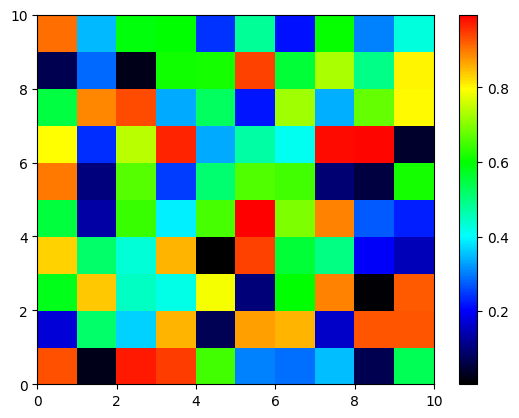

In [34]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors in RGB format
colors = [
    (0.0, 0.0, 0.0),  # Black
    (0.0, 0.0, 1.0),  # Blue
    # (0.5, 0.0, 1.0),  # Violet
    (0.0, 1.0, 1.0),  # Cyan
    (0.0, 1.0, 0.0),  # Green
    (1.0, 1.0, 0.0),  # Yellow
    (1.0, 0.0, 0.0)   # Red
]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

# Example usage
plt.pcolor(np.random.rand(10,10), cmap=custom_cmap)
plt.colorbar()
plt.show()


/var/folders/bh/qf1v6xm50lz_nh8mfd1m_fgm0000gn/T/ipykernel_38160/3359162495.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = custom_cmaps.get(param, plt.cm.get_cmap('viridis'))
/var/folders/bh/qf1v6xm50lz_nh8mfd1m_fgm0000gn/T/ipykernel_38160/3359162495.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = custom_cmaps.get('tissue_types', plt.cm.get_cmap('tab20'))


[<Figure size 1500x1200 with 12 Axes>,
 <Figure size 1500x1000 with 4 Axes>,
 <Figure size 1500x1000 with 5 Axes>]

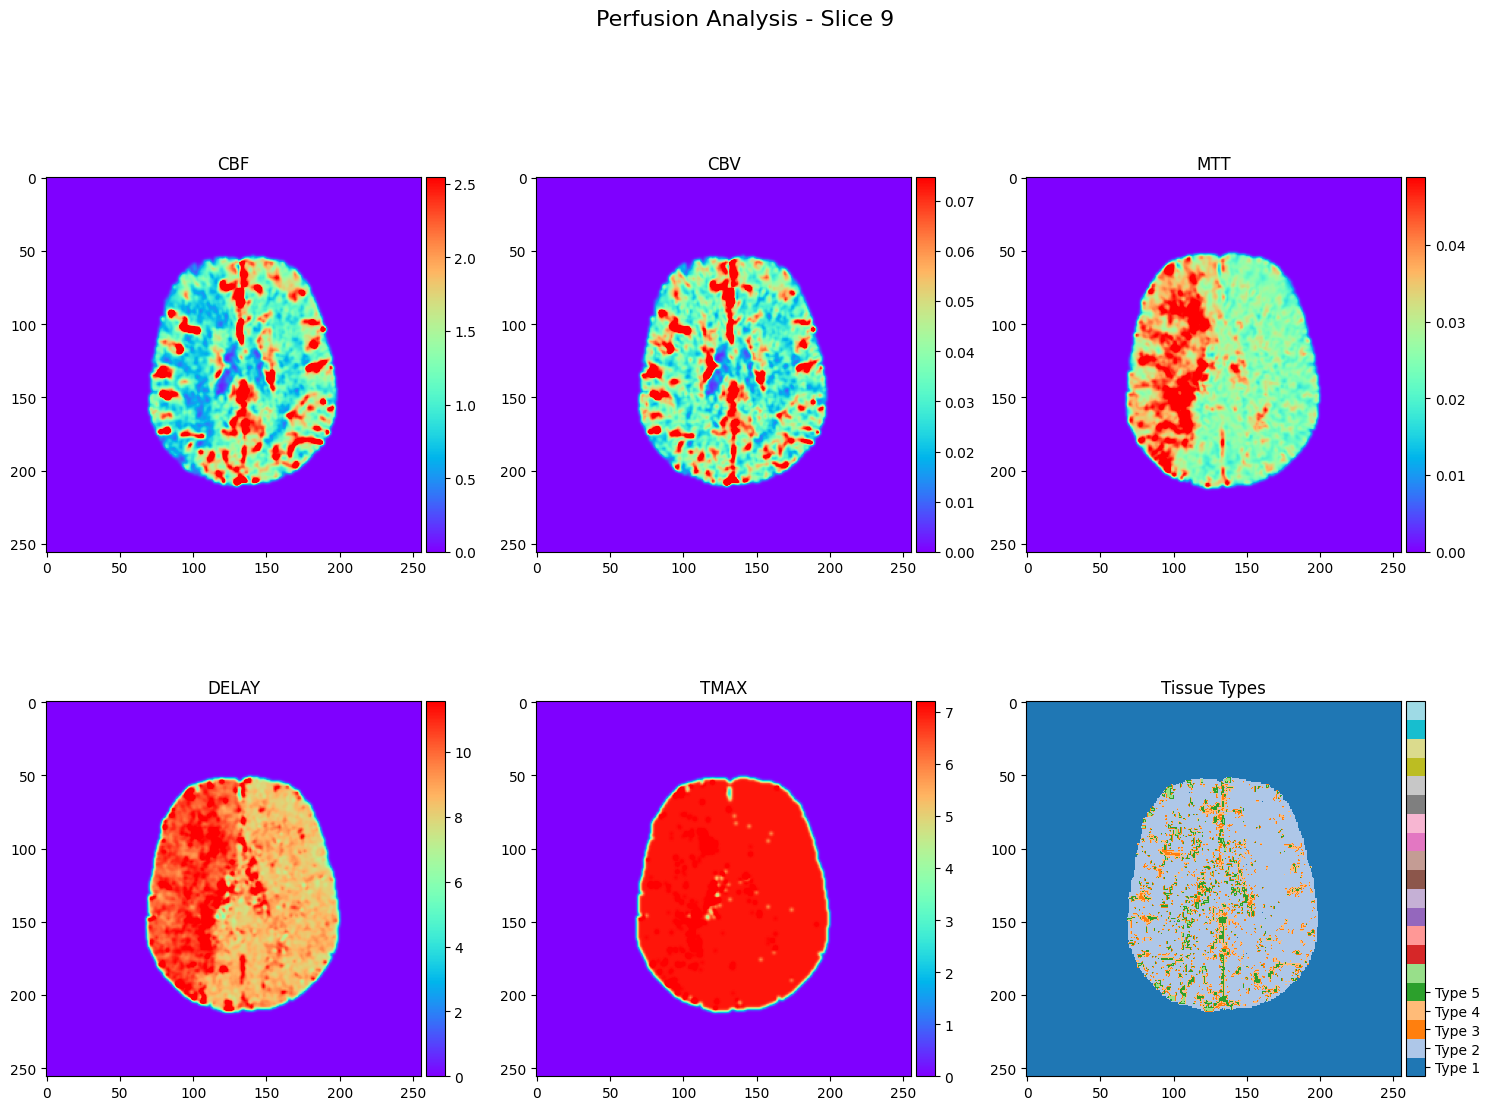

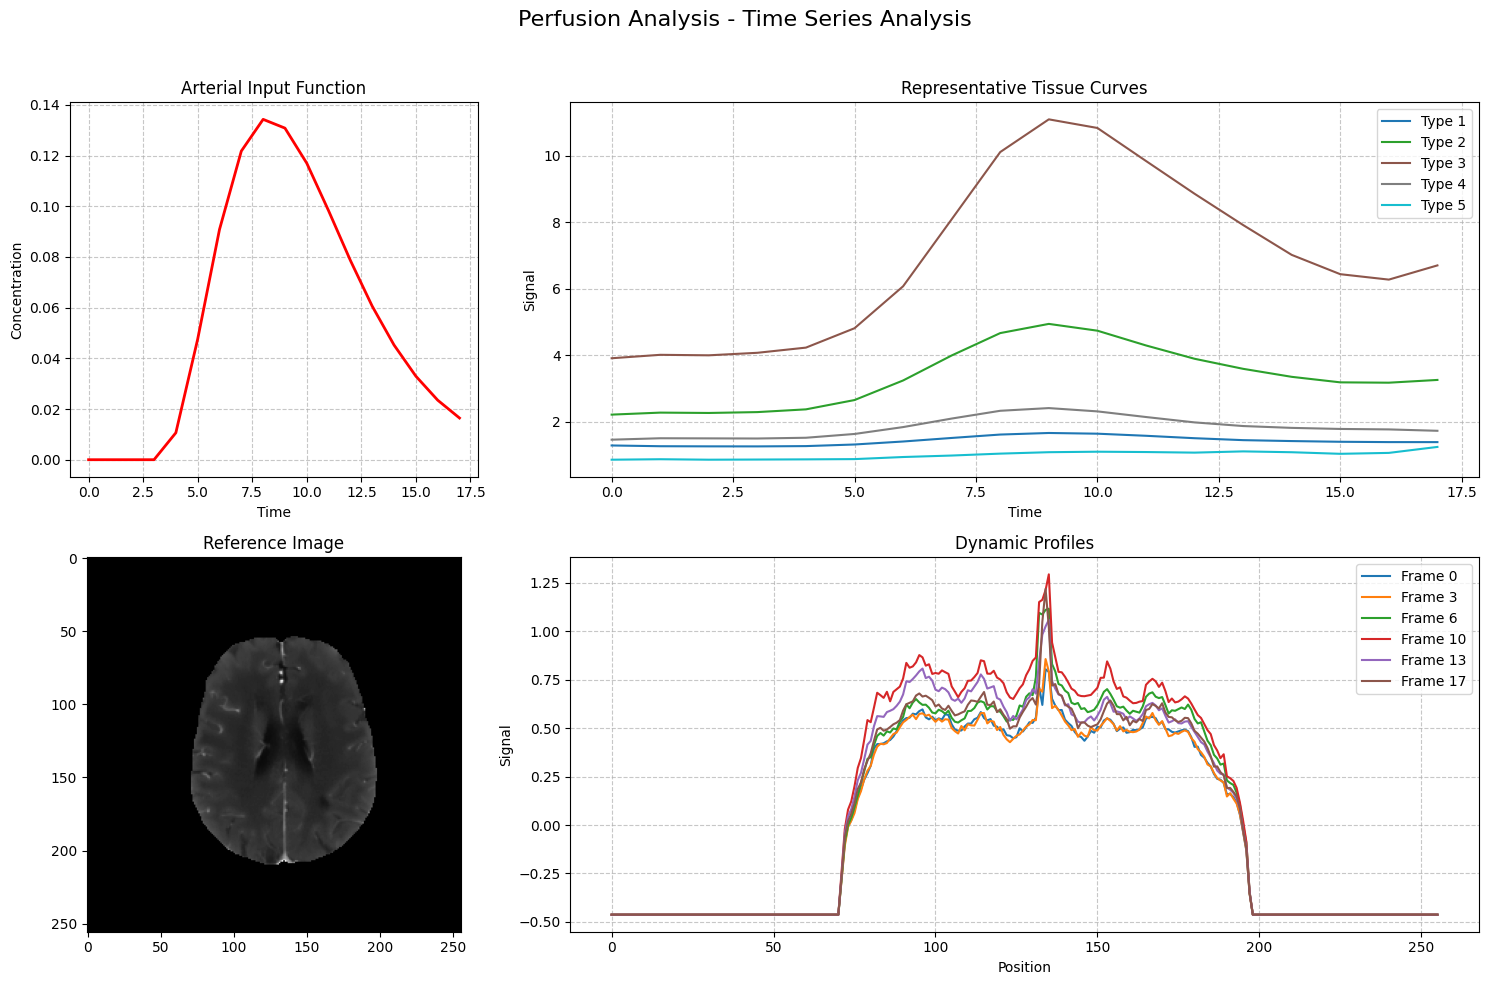

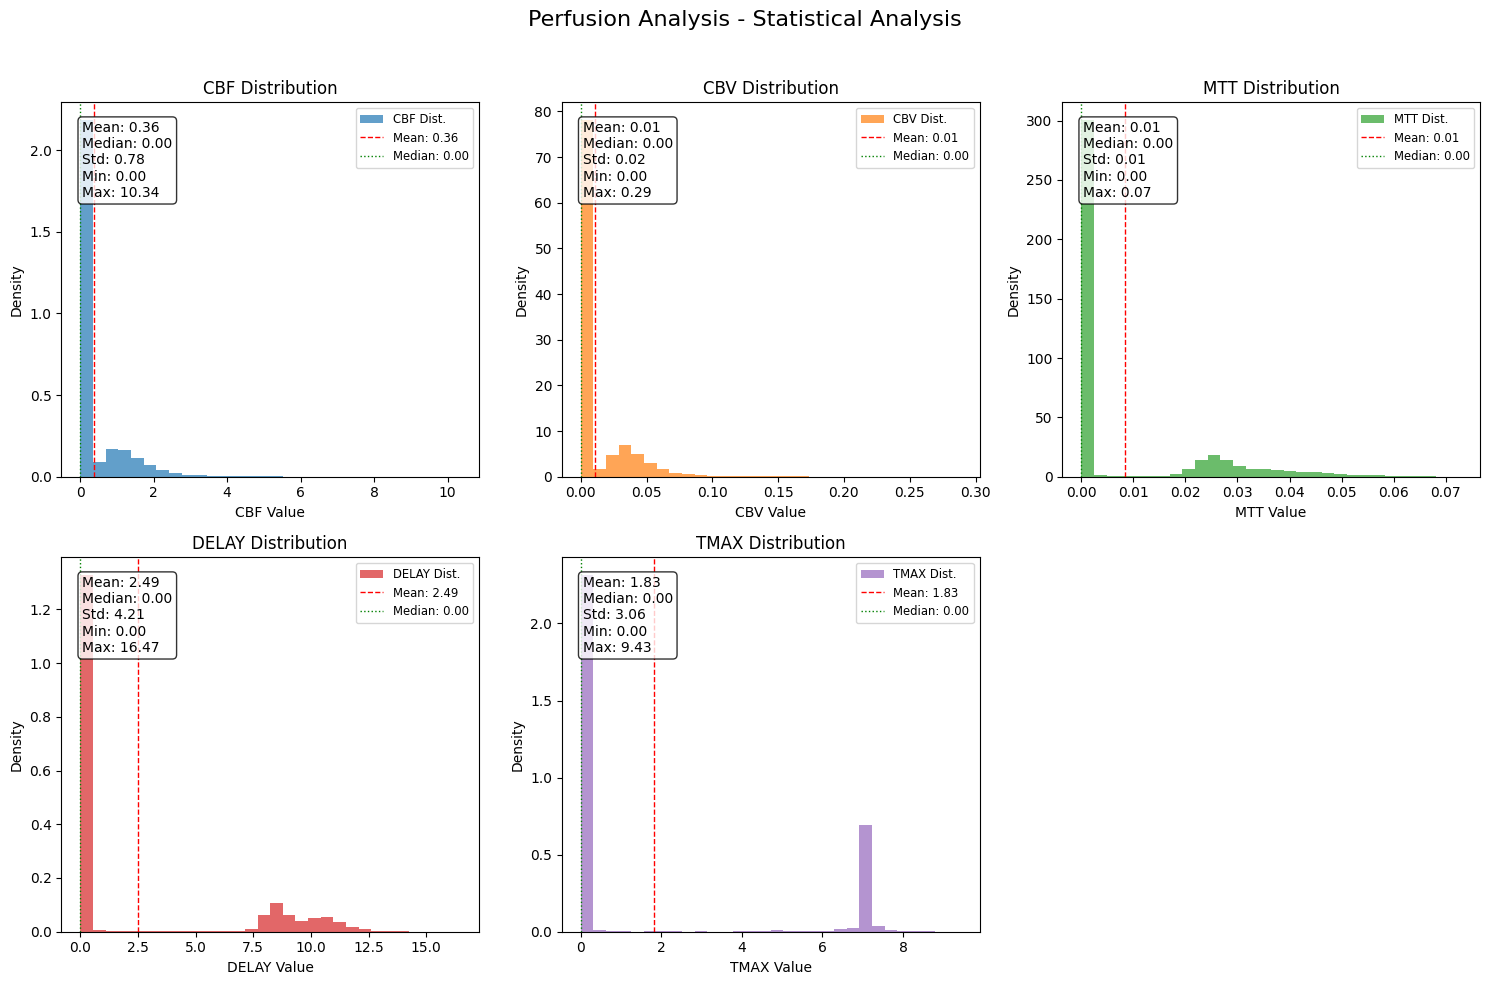

In [35]:
visualize_perfusion_data(maps, v, slice_idx=9, custom_cmaps={'cbf': 'rainbow', 'cbv': 'rainbow', 'mtt': 'rainbow', 'delay': 'rainbow', 'tmax': 'rainbow'})

In [52]:


def calculate_max_slope_perfusion(volume_4d, time_values=None, aif_method='auto',
                                  smooth_sigma=0.5, spatial_smooth=0.5, 
                                  smooth_output=True, n_jobs=-1):
    """
    Calculate perfusion maps using the maximum slope method.
    
    Parameters:
    -----------
    volume_4d : numpy.ndarray
        4D array with dimensions (time, z, y, x) or (time, y, x) for 2D+time data
    time_values : numpy.ndarray, optional
        Array of time points in seconds. If None, assumes uniform sampling at 1s intervals.
    aif_method : str or tuple, optional
        Method for AIF selection: 'auto', 'pca', 'features', or ROI coordinates
    smooth_sigma : float, optional
        Sigma for Gaussian smoothing of concentration curves
    spatial_smooth : float, optional
        Sigma for spatial Gaussian smoothing of input volume (0 = no smoothing)
    smooth_output : bool, optional
        Whether to apply spatial smoothing to output perfusion maps
    n_jobs : int, optional
        Number of parallel jobs for processing. -1 means use all processors.
        
    Returns:
    --------
    dict
        Dictionary containing perfusion maps
    """
    from scipy.ndimage import gaussian_filter
    from scipy.optimize import curve_fit
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import numpy as np
    from joblib import Parallel, delayed
    
    # Get dimensions and handle 2D+time vs 3D+time
    if len(volume_4d.shape) == 4:  # 3D+time
        n_timepoints, n_slices, n_rows, n_cols = volume_4d.shape
        is_3d = True
    else:  # 2D+time
        n_timepoints, n_rows, n_cols = volume_4d.shape
        n_slices = 1
        is_3d = False
        volume_4d = volume_4d.reshape(n_timepoints, 1, n_rows, n_cols)
    
    # Apply spatial smoothing to input volume if requested
    if spatial_smooth > 0:
        for t in range(n_timepoints):
            for z in range(n_slices):
                volume_4d[t, z] = gaussian_filter(volume_4d[t, z], sigma=spatial_smooth)
    
    # Create time axis if not provided
    if time_values is None:
        time_values = np.arange(n_timepoints)
    dt = np.mean(np.diff(time_values))
    
    # Create output maps
    cbf_map = np.zeros((n_slices, n_rows, n_cols))
    cbv_map = np.zeros((n_slices, n_rows, n_cols))
    mtt_map = np.zeros((n_slices, n_rows, n_cols))
    arrival_map = np.zeros((n_slices, n_rows, n_cols))
    peak_map = np.zeros((n_slices, n_rows, n_cols))
    
    # Extract all curves and reshape for analysis
    curves = volume_4d.reshape(n_timepoints, -1)
    n_voxels = curves.shape[1]
    
    # Filter out flat or noisy curves - use vectorized operations
    curve_std = np.std(curves, axis=0)
    valid_curves_mask = curve_std > np.percentile(curve_std, 10)
    valid_curves = curves[:, valid_curves_mask]
    valid_indices = np.where(valid_curves_mask)[0]
    
    # Early exit if no valid curves
    if len(valid_indices) == 0:
        perfusion_maps = {
            'cbf': cbf_map if not is_3d else cbf_map.squeeze(),
            'cbv': cbv_map if not is_3d else cbv_map.squeeze(),
            'mtt': mtt_map if not is_3d else mtt_map.squeeze(),
            'arrival': arrival_map if not is_3d else arrival_map.squeeze(),
            'peak': peak_map if not is_3d else peak_map.squeeze(),
            'aif': np.zeros(n_timepoints),
            'time_values': time_values
        }
        return perfusion_maps
    
    # Baseline correction - use vectorized operations
    baseline_idx = max(1, int(n_timepoints * 0.1))  # Use first 10% as baseline
    baselines = np.mean(valid_curves[:baseline_idx, :], axis=0)
    valid_curves_corr = valid_curves - baselines
    
    # Smooth curves efficiently
    for i in range(valid_curves_corr.shape[1]):
        valid_curves_corr[:, i] = gaussian_filter(valid_curves_corr[:, i], sigma=smooth_sigma)
    
    # Extract curve features efficiently
    peak_vals = np.max(valid_curves_corr, axis=0)
    peak_indices = np.argmax(valid_curves_corr, axis=0)
    derivatives = np.diff(valid_curves_corr, axis=0)
    max_derivatives = np.max(derivatives, axis=0)
    
    # Calculate wash-out slopes (more complex - can't fully vectorize)
    min_derivatives = np.zeros(valid_curves_corr.shape[1])
    for i in range(valid_curves_corr.shape[1]):
        peak_idx = int(peak_indices[i])
        if peak_idx < n_timepoints - 2:
            min_derivatives[i] = np.min(derivatives[peak_idx:, i])
    
    # Area under curve
    auc_values = np.trapz(valid_curves_corr, axis=0)
    
    # Combine features
    curve_features = np.vstack([peak_vals, peak_indices, max_derivatives, 
                                min_derivatives, auc_values]).T
    
    # Normalize features
    scaler = StandardScaler()
    curve_features_norm = scaler.fit_transform(curve_features)
    
    # AIF Selection (Same as in the deconvolution method)
    def gamma_variate(t, A, alpha, beta, t0):
        term = np.zeros_like(t, dtype=float)
        mask = t > t0
        term[mask] = ((t[mask] - t0) / beta) ** alpha * np.exp(-(t[mask] - t0) / beta)
        return A * term
    
    if isinstance(aif_method, tuple):
        # Extract AIF from specified ROI
        if is_3d and len(aif_method) == 3:
            (z_start, z_end), (y_start, y_end), (x_start, x_end) = aif_method
            aif_indices = []
            for z in range(z_start, z_end):
                for y in range(y_start, y_end):
                    for x in range(x_start, x_end):
                        idx = z * n_rows * n_cols + y * n_cols + x
                        if idx < n_voxels:
                            aif_indices.append(idx)
            aif_curve = np.mean(curves[:, aif_indices], axis=1) if aif_indices else np.zeros(n_timepoints)
        elif not is_3d and len(aif_method) == 2:
            (y_start, y_end), (x_start, x_end) = aif_method
            aif_indices = []
            for y in range(y_start, y_end):
                for x in range(x_start, x_end):
                    idx = y * n_cols + x
                    if idx < n_voxels:
                        aif_indices.append(idx)
            aif_curve = np.mean(curves[:, aif_indices], axis=1) if aif_indices else np.zeros(n_timepoints)
        else:
            raise ValueError("ROI dimensions don't match volume dimensions")
    else:
        # Automated AIF selection
        if aif_method == 'auto' or aif_method == 'features':
            # Use vectorized operations for feature normalization
            features_01 = np.zeros_like(curve_features)
            for i in range(curve_features.shape[1]):
                feat_min = np.min(curve_features[:, i])
                feat_max = np.max(curve_features[:, i])
                if feat_max > feat_min:
                    features_01[:, i] = (curve_features[:, i] - feat_min) / (feat_max - feat_min)
            
            # Score for AIF likelihood
            aif_scores = (1 - features_01[:, 1]) * 0.4 + features_01[:, 0] * 0.3 + features_01[:, 2] * 0.3
            
            # Select top candidates
            n_candidates = min(10, len(aif_scores))
            top_indices = np.argsort(aif_scores)[-n_candidates:]
            
            # Extract the curves and average them
            top_voxel_indices = [valid_indices[i] for i in top_indices]
            aif_candidates = curves[:, top_voxel_indices]
            aif_curve = np.mean(aif_candidates, axis=1)
        elif aif_method == 'pca':
            # Use PCA for AIF extraction
            pca = PCA(n_components=min(5, valid_curves_corr.shape[1]))
            pca.fit(valid_curves_corr.T)
            
            component_scores = []
            for comp in pca.components_:
                peak_val = np.max(comp)
                peak_idx = np.argmax(comp)
                early_factor = 1.0 - peak_idx/n_timepoints
                sharpness = np.max(np.diff(comp)) if peak_idx > 0 else 0
                score = early_factor * 0.4 + (peak_val/np.max(pca.components_)) * 0.3 + (sharpness/np.max(np.diff(pca.components_))) * 0.3
                component_scores.append(score)
            
            best_component_idx = np.argmax(component_scores)
            best_component = pca.components_[best_component_idx]
            
            if np.min(best_component) < 0 and np.abs(np.min(best_component)) > np.max(best_component):
                best_component = -best_component
                
            aif_curve = best_component - np.min(best_component)
            if np.max(aif_curve) > 0:
                aif_curve = aif_curve / np.max(aif_curve) * np.max(valid_curves_corr)
        else:
            raise ValueError(f"Unknown AIF selection method: {aif_method}")
    
    # Process AIF
    aif_curve = gaussian_filter(aif_curve, sigma=smooth_sigma)
    aif_baseline = np.mean(aif_curve[:baseline_idx])
    aif_curve = np.maximum(aif_curve - aif_baseline, 0)  # Baseline correction and non-negativity
    
    # Try to fit gamma-variate to AIF
    try:
        p0 = [np.max(aif_curve), 3.0, 1.5, np.argmax(aif_curve) * 0.5]
        bounds = ([0, 0.1, 0.1, 0], [np.inf, 10, 10, np.argmax(aif_curve)])
        
        popt, _ = curve_fit(gamma_variate, np.arange(len(aif_curve)), aif_curve, 
                            p0=p0, bounds=bounds, maxfev=5000)
        
        aif_fitted = gamma_variate(np.arange(len(aif_curve)), *popt)
        
        fit_quality = 1 - np.sum((aif_curve - aif_fitted)**2) / np.sum((aif_curve - np.mean(aif_curve))**2)
        if fit_quality > 0.7:
            aif_curve = aif_fitted
    except:
        pass
    
    # Calculate AIF maximum slope and peak value
    aif_derivatives = np.diff(aif_curve)
    aif_max_upslope = np.max(aif_derivatives)
    aif_peak = np.max(aif_curve)
    
    # Maximum-slope method processing
    def process_max_slope_voxel(z, y, x):
        tissue_curve = volume_4d[:, z, y, x].copy()
        
        # Skip if curve is flat or noisy
        if np.std(tissue_curve) < 1e-6:
            return None
        
        # Baseline correction and smoothing
        tissue_baseline = np.mean(tissue_curve[:baseline_idx])
        tissue_curve = tissue_curve - tissue_baseline
        tissue_curve = gaussian_filter(tissue_curve, sigma=smooth_sigma)
        tissue_curve = np.maximum(tissue_curve, 0)  # Non-negativity constraint
        
        # Calculate max upslope
        tissue_derivatives = np.diff(tissue_curve)
        tissue_max_upslope = np.max(tissue_derivatives)
        
        # Calculate CBF using maximum slope method
        # CBF is proportional to the ratio of tissue's max upslope to AIF's peak
        if aif_peak > 0:
            cbf = tissue_max_upslope / aif_peak
        else:
            cbf = 0
        
        # Calculate CBV (area ratio)
        tissue_area = np.trapz(tissue_curve, time_values)
        aif_area = np.trapz(aif_curve, time_values)
        if aif_area > 0:
            cbv = tissue_area / aif_area
        else:
            cbv = 0
        
        # Calculate MTT (CBV/CBF)
        if cbf > 0:
            mtt = cbv / cbf
        else:
            mtt = 0
        
        # Find arrival time (first point where curve exceeds baseline by significant amount)
        threshold = 0.1 * np.max(tissue_curve)
        arrival_indices = np.where(tissue_curve > threshold)[0]
        arrival_time = time_values[arrival_indices[0]] if len(arrival_indices) > 0 else 0
        
        # Peak time
        peak_time = time_values[np.argmax(tissue_curve)]
        
        return (z, y, x, cbf, cbv, mtt, arrival_time, peak_time)
    
    # Generate all voxel coordinates
    coords = [(z, y, x) for z in range(n_slices) for y in range(n_rows) for x in range(n_cols)]
    
    # Process voxels in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_max_slope_voxel)(z, y, x) for z, y, x in coords
    )
    
    # Populate maps from parallel results
    for result in results:
        if result is not None:
            z, y, x, cbf_val, cbv_val, mtt_val, arrival_val, peak_val = result
            cbf_map[z, y, x] = cbf_val
            cbv_map[z, y, x] = cbv_val
            mtt_map[z, y, x] = mtt_val
            arrival_map[z, y, x] = arrival_val
            peak_map[z, y, x] = peak_val
    
    # Cleanup: remove extreme values
    for map_array in [cbf_map, cbv_map, mtt_map]:
        positive_values = map_array[map_array > 0]
        if len(positive_values) > 0:
            threshold = np.percentile(positive_values, 99)
            map_array[map_array > threshold] = threshold
    
    # Apply spatial smoothing to output maps if requested
    if smooth_output:
        output_smooth_sigma = max(1.0, spatial_smooth)
        for z in range(n_slices):
            cbf_map[z] = gaussian_filter(cbf_map[z], sigma=output_smooth_sigma)
            cbv_map[z] = gaussian_filter(cbv_map[z], sigma=output_smooth_sigma)
            mtt_map[z] = gaussian_filter(mtt_map[z], sigma=output_smooth_sigma)
            arrival_map[z] = gaussian_filter(arrival_map[z], sigma=output_smooth_sigma)
            peak_map[z] = gaussian_filter(peak_map[z], sigma=output_smooth_sigma)

    # Return results
    perfusion_maps = {
        'cbf': cbf_map if not is_3d else cbf_map.squeeze(),
        'cbv': cbv_map if not is_3d else cbv_map.squeeze(),
        'mtt': mtt_map if not is_3d else mtt_map.squeeze(),
        'arrival': arrival_map if not is_3d else arrival_map.squeeze(),
        'peak': peak_map if not is_3d else peak_map.squeeze(),
        'aif': aif_curve,
        'time_values': time_values
    }
    
    return perfusion_maps

In [53]:
maps_2 = calculate_max_slope_perfusion(v)

/var/folders/bh/qf1v6xm50lz_nh8mfd1m_fgm0000gn/T/ipykernel_38160/3359162495.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = custom_cmaps.get(param, plt.cm.get_cmap('viridis'))


[<Figure size 1500x1200 with 6 Axes>,
 <Figure size 1500x1000 with 3 Axes>,
 <Figure size 1500x1000 with 3 Axes>]

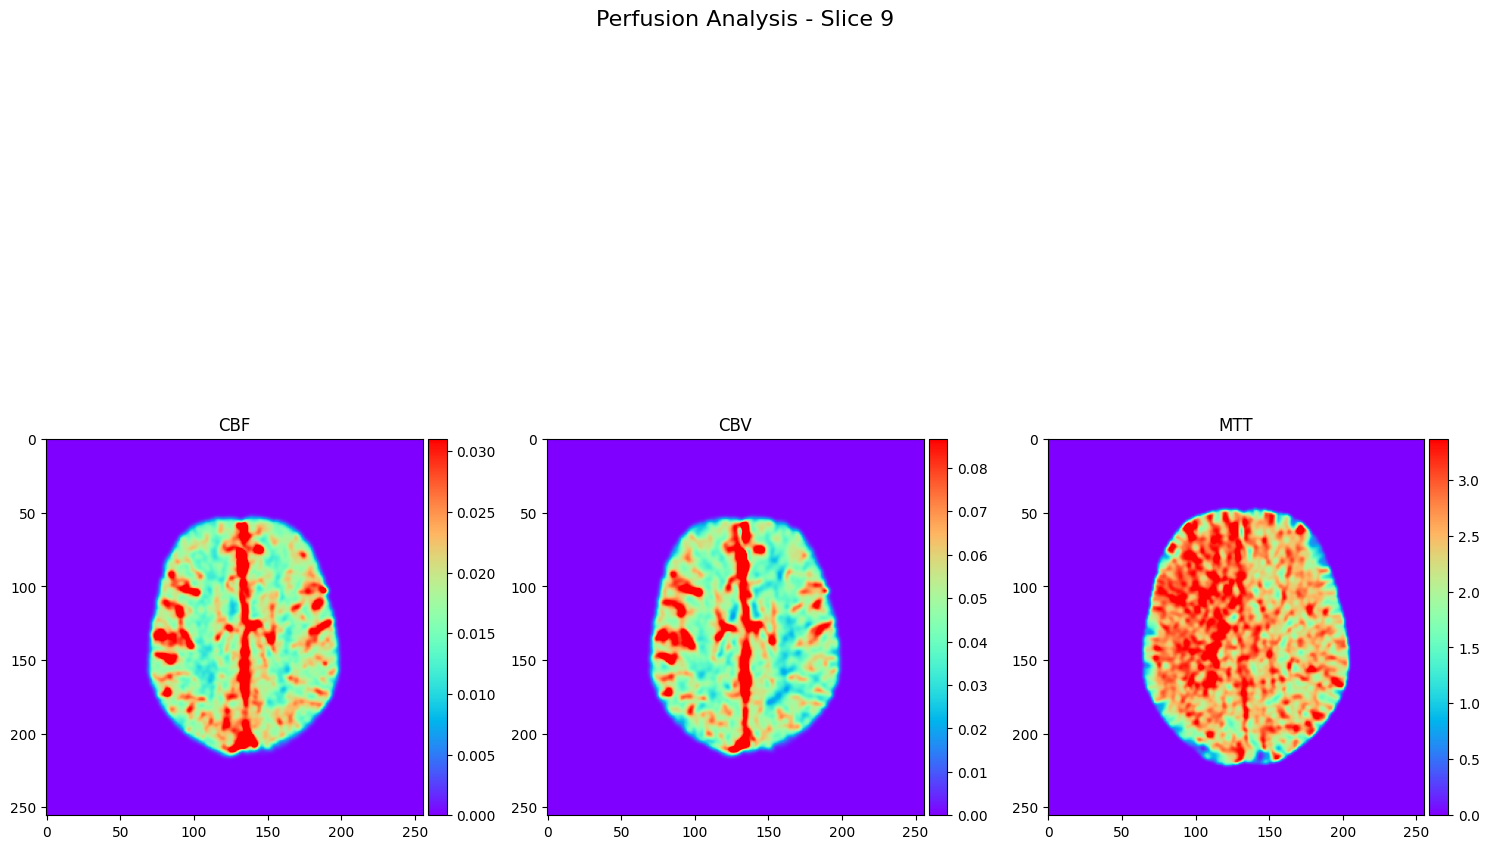

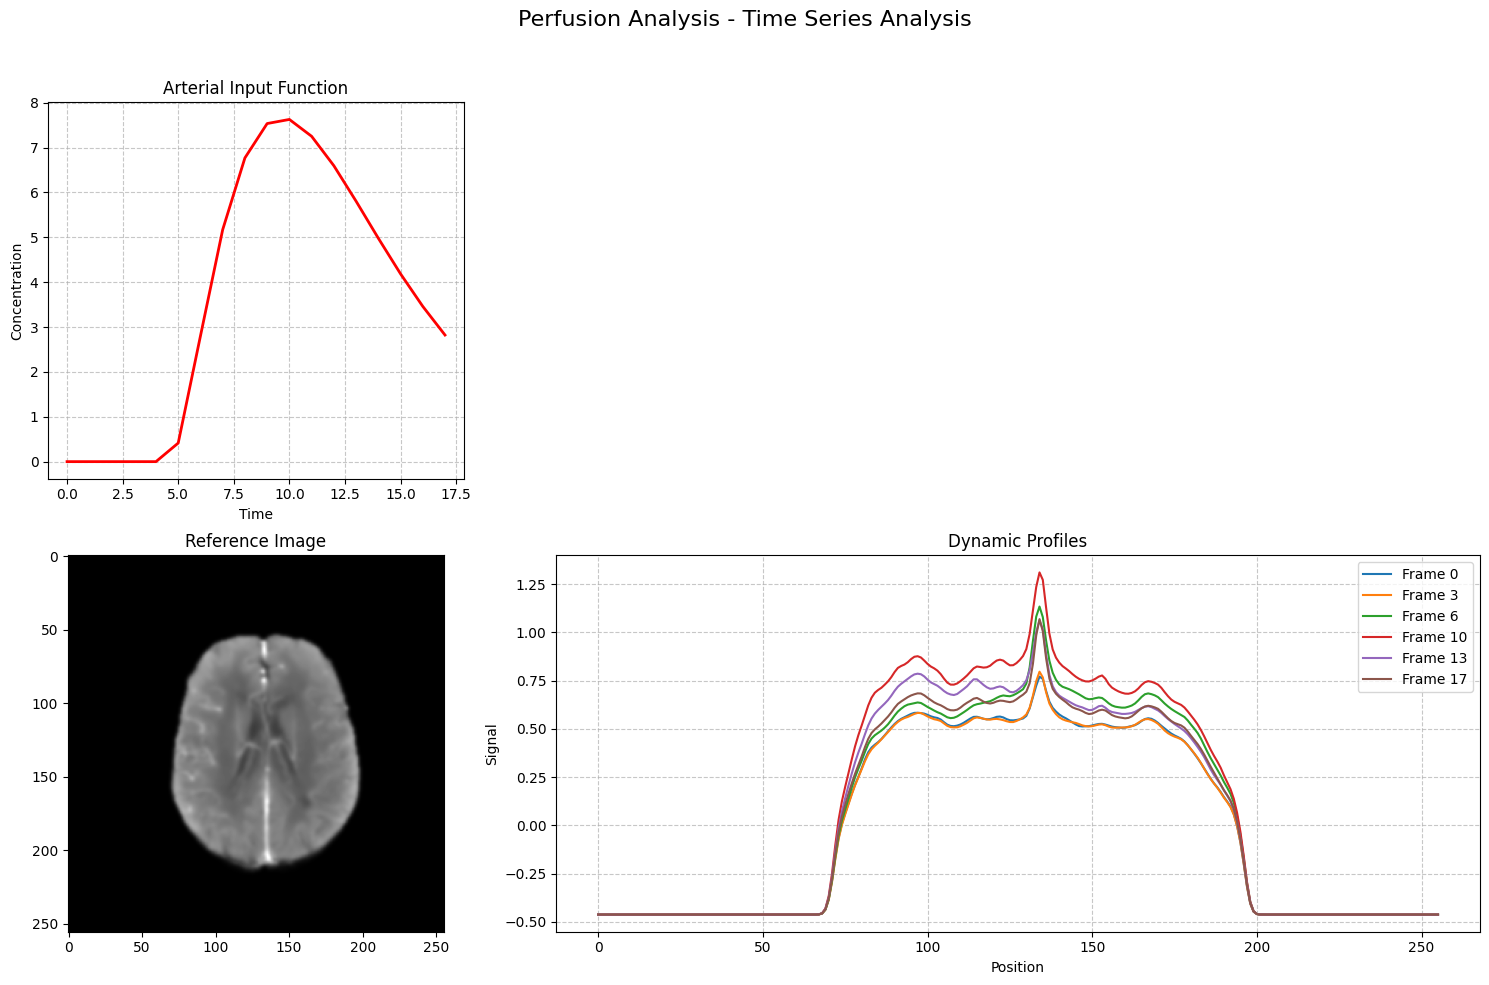

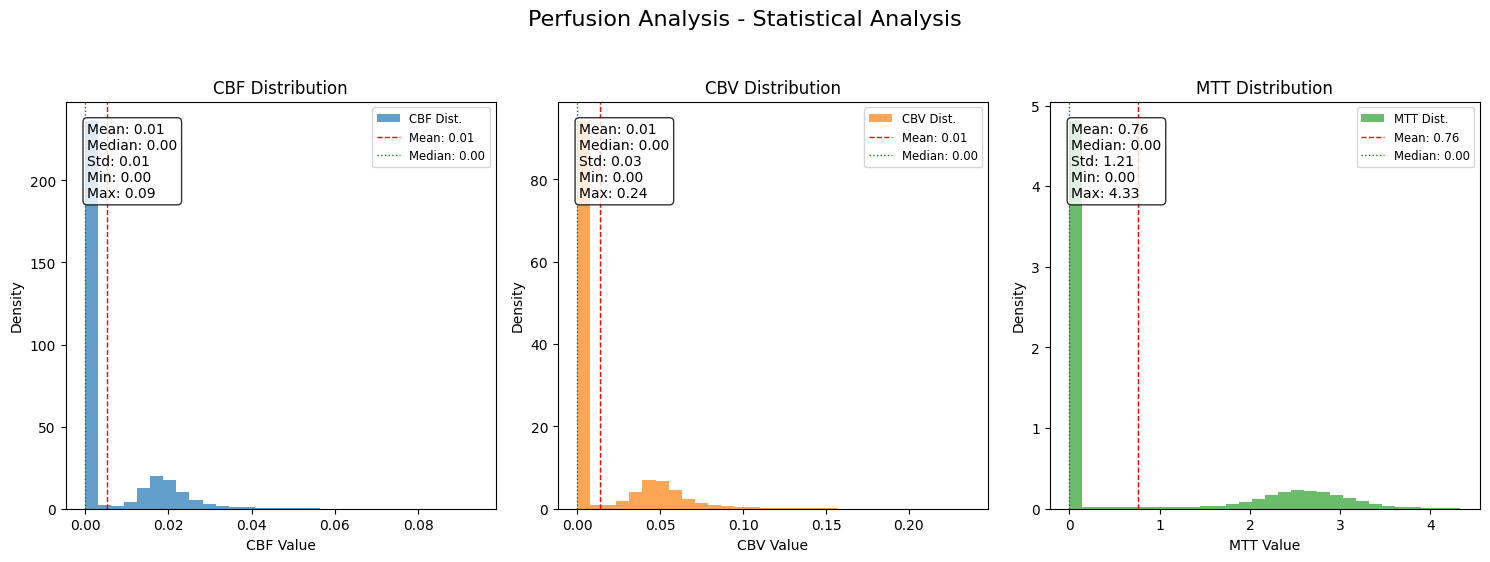

In [54]:
visualize_perfusion_data(maps_2, v, slice_idx=9, custom_cmaps={'cbf': 'rainbow', 'cbv': 'rainbow', 'mtt': 'rainbow', 'delay': 'rainbow', 'tmax': 'rainbow'})